In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
from monty.serialization import loadfn

#Set to True if using charge_throughput, False if using cycle life/X.capacity_0.8
ct = True

In [4]:
path = "./"
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

In [5]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [6]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5',
                       'X.integrated_time_temperature_cycles_1:100']
#                        'X.min_internal_resistance_cycles_2:100',
#                        'X.internal_resistance_difference_cycles_2:100']

internal_resistance = ['X.min_internal_resistance_cycles_2:100', 
                       'X.internal_resistance_difference_cycles_2:100']

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [7]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## Old Data

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='charge_throughput'>

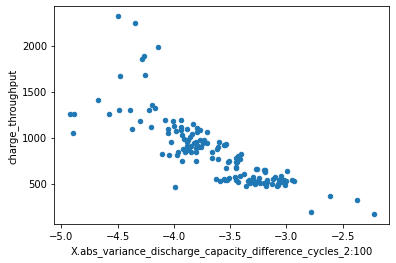

In [6]:
old_ct.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = y)

In [7]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

### Variance Model

In [8]:
# Variance model
X_train_var = old_ct.iloc[train_ind][[variance_model_features]]
y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][[variance_model_features]]
y_test = old_ct.iloc[test_ind][[y]]

In [9]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  282.9219171385274
Test RMSE:  214.30059910503815
Mean % Train Error:  0.2188573334295043
Mean % Test Error:  0.1485010582836219


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

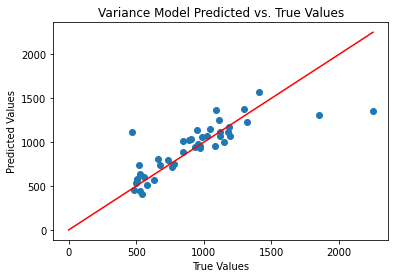

In [10]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [11]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 1.0
Test RMSE:  214.31490921731063


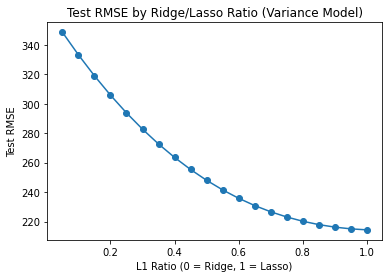

In [12]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN)')

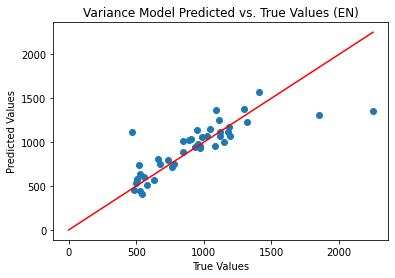

In [13]:
#Elastic Net
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN)")

#### From paper (Variance Model)
* Training RMSE: 103
* Test RMSE: 138
* Mean % Train Error: 14.1
* Mean % Test Error: 14.7

### Discharge Model

In [14]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))

Discharge Basic Linear Regression Model
Training RMSE:  198.9805299456749
Test RMSE:  335.3509910185471


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

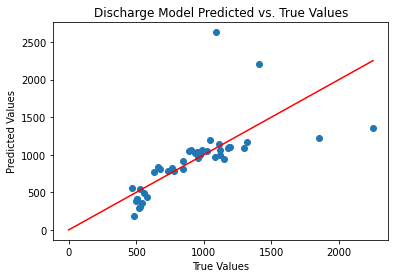

In [15]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [16]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.7
Test RMSE:  233.0789326433852


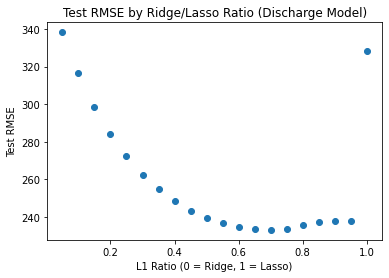

In [17]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

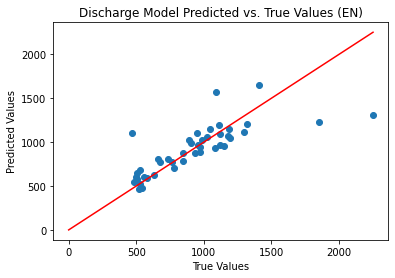

In [18]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

#### From paper (Discharge Model)
* Training RMSE: 76
* Test RMSE: 91
* Mean % Train Error: 9.8
* Mean % Test Error: 13.0

### Full Model

In [19]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features + internal_resistance]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features + internal_resistance]
y_test = old_ct.iloc[test_ind][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  181.94226670313765
Test RMSE:  215.90088707153535
Mean % Train Error:  0.16966614746182565
Mean % Test Error:  0.17037614940599616


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

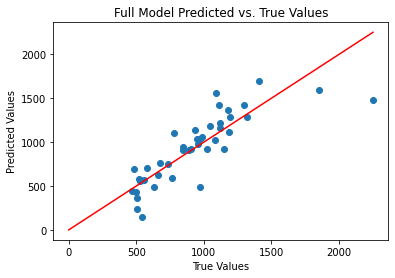

In [20]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [21]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 0.2
Test RMSE:  365.1081765379092


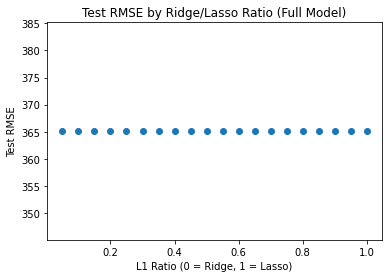

In [22]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN)')

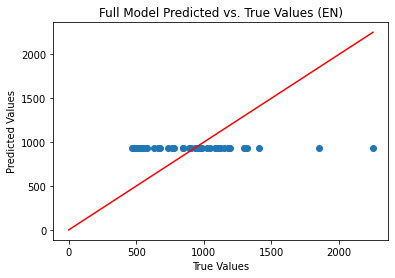

In [23]:
#Elastic Net
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN)")

#### From paper (Full Model)
* Training RMSE: 51
* Test RMSE: 118
* Mean % Train Error: 5.6
* Mean % Test Error: 14.1

### Old Data Plots

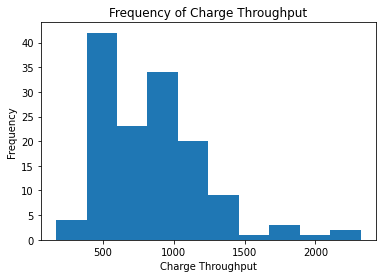

In [24]:
plt.hist(old_ct[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life')

In [25]:
old_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", "Var (Paper)",
                                                           "Disc (Linear)", "Disc (E.N.)", "Disc (Paper)",
                                                           "Full (Linear)", "Full (E.N.)", "Full (Paper)"],
                               
                               "Model": ["Variance", "Variance", "Variance",
                                         "Discharge", "Discharge", "Discharge",
                                         "Full", "Full", "Full"],
                                        
                               "Source": ["Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en, 103,
                                              rmse_train_dis, rmse_train_dis_en, 76,
                                              rmse_train_full, rmse_train_full_en, 51],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en, 138,
                                             rmse_test_dis, rmse_test_dis_en, 91, 
                                             rmse_test_full, rmse_test_full_en, 118]})#,
                               
#                                "Mean % Train Error": [mape_train_var, 14.1,
#                                                       mape_train_dis, 9.8,
#                                                       mape_train_full, 5.6],
                               
#                                "Mean % Test Error": [mape_test_var, 14.7,
#                                                      mape_test_dis, 13.0,
#                                                      mape_test_full, 14.1]})

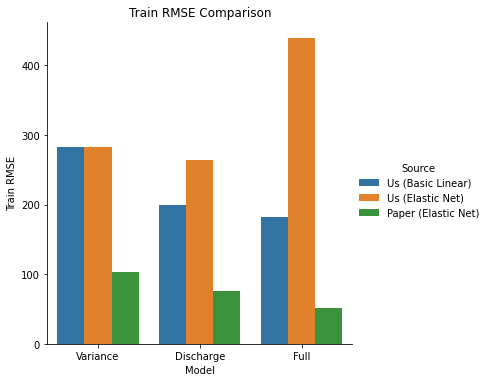

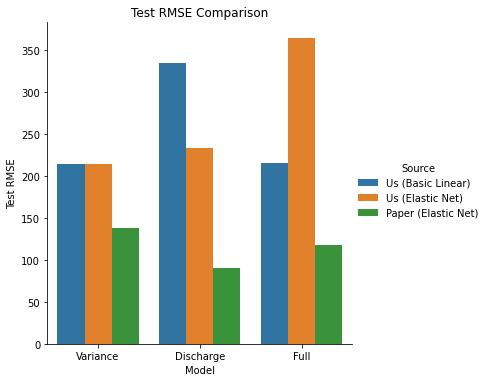

In [26]:
for column in old_data_metrics.columns[3:5]:
    sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")

## New Data

In [9]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

In [10]:
new_ct["battery_index"] = new_ct["battery"].str[-2:].astype('int')

In [11]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [30]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

### Variance Model

In [31]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
y_train = new_ct_full.iloc[train_ind][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
y_test = new_ct_full.iloc[test_ind][[y]]

In [32]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  497.3912214196244
Test RMSE:  626.8553139149482
Mean % Train Error:  0.13972198795934598
Mean % Test Error:  0.15944604392611542


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR)')

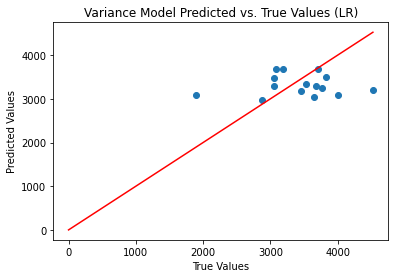

In [33]:
# Linear Regression
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR)")

In [34]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.95
Test RMSE:  610.0412341611211


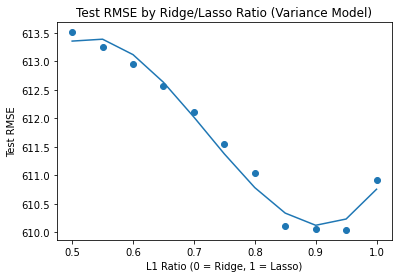

In [35]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN)')

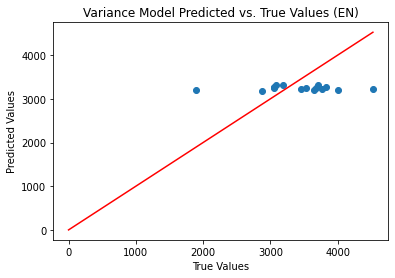

In [36]:
#Elastic Net
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN)")

### Discharge Model

In [37]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
# print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  126.9582047155387
Test RMSE:  740.8758519974643


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR)')

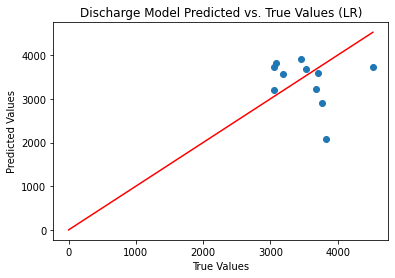

In [38]:
# Linear Regression
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR)")

In [39]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.95
Test RMSE:  401.47895367971967


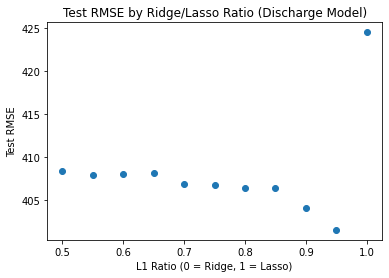

In [40]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

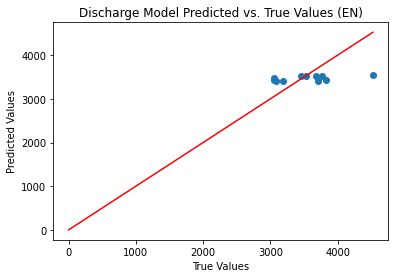

In [41]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

### Full Model

In [42]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y_test = new_ct_full.iloc[X_test_full.index][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  235.70674038535276
Test RMSE:  566.7529723748985
Mean % Train Error:  0.048179538730276264
Mean % Test Error:  0.11053628793016268


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR)')

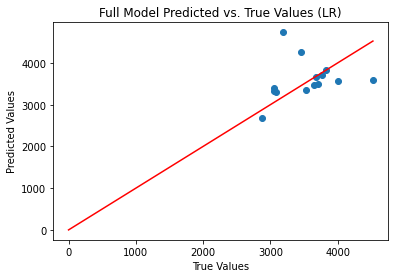

In [43]:
#Linear Regression
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR)")

In [44]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )
    
    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 0.25
Test RMSE:  487.3086357939832


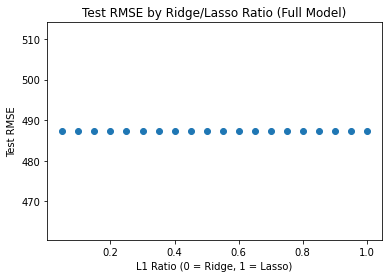

In [45]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN)')

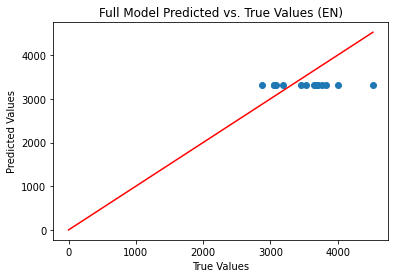

In [46]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN)")

### New Data Plots

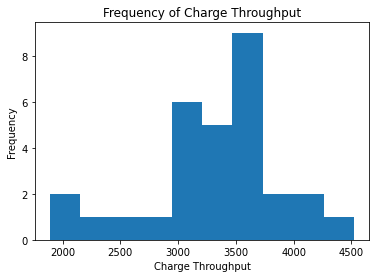

In [47]:
plt.hist(new_ct_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life (New Data)')

In [48]:
new_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                           "Disc (Linear)", "Disc (E.N.)",
                                                           "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en,]})#,

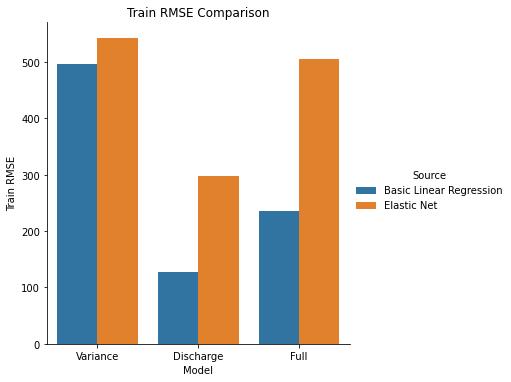

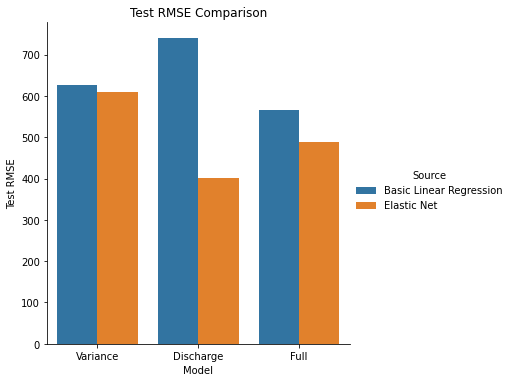

In [49]:
for column in new_data_metrics.columns[3:5]:
    sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")

## New + Old Data

In [12]:
old_ct["Source"] = -1
new_ct_full["Source"] = 1
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

variance_model_features = [variance_model_features, "Source"]
discharge_model_features.append("Source")
full_model_features.append("Source")

In [51]:
full_data["Source"]

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
164    1
165    1
166    1
167    1
168    1
Name: Source, Length: 169, dtype: int64

In [31]:
#True if training on old data and testing on new data, false otherwise
train_old_test_new = False

#True if log transforming response
transformations = True

if train_old_test_new:
    train_ind = [i for i in range(1,83)]
    test_ind = [j for j in range(139,168)]
    
else:
    train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
            35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
            69, 71, 73, 75, 77, 79, 81]
    test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
            34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
            68, 70, 72, 74, 76, 78, 80, 82, 83]

    train_ind = train_ind + list(range(old_ct.shape[0],old_ct.shape[0] + new_ct.shape[0], 2))
    test_ind = test_ind + list(range(old_ct.shape[0] + 1,old_ct.shape[0] + new_ct.shape[0], 2))

### Variance Model

In [32]:
# Variance model
X_train_var = full_data.iloc[train_ind][variance_model_features]
y_train = full_data.iloc[train_ind][[y]]

X_test_var = full_data.iloc[test_ind][variance_model_features]
y_test = full_data.iloc[test_ind][[y]]

# log transformation
if transformations:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [33]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  0.3828399640793056
Test RMSE:  0.3590611579661618
Mean % Train Error:  0.039298444248500056
Mean % Test Error:  0.03971716487073091


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

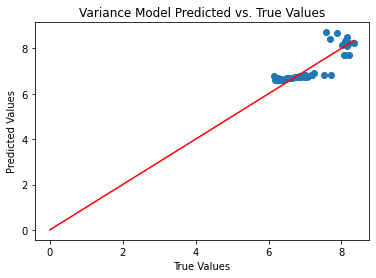

In [34]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [35]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.15
Test RMSE:  0.33628777289249234


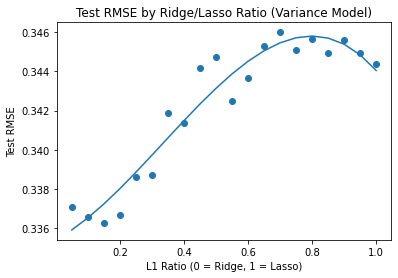

In [36]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN)')

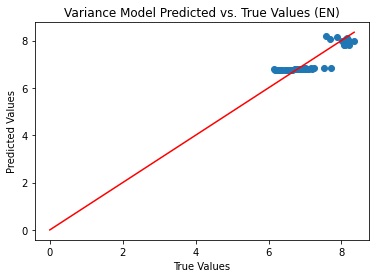

In [37]:
#Elastic Net
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN)")

### Discharge Model

In [38]:
full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan).isna().sum()

X.abs_min_discharge_capacity_difference_cycles_2:100         4
X.abs_variance_discharge_capacity_difference_cycles_2:100    3
X.abs_skew_discharge_capacity_difference_cycles_2:100        3
X.abs_kurtosis_discharge_capacity_difference_cycles_2:100    3
X.discharge_capacity_cycle_2                                 0
X.max_discharge_capacity_difference                          0
Source                                                       0
dtype: int64

In [52]:
# discharge model
X_train_dis = full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis = full_data.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_test = full_data.iloc[X_test_dis.index][[y]]

if transformations:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  0.28691203661877784
Test RMSE:  0.3795918386885068
Mean % Train Error:  0.03191189794655491
Mean % Test Error:  0.03689240430711559


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

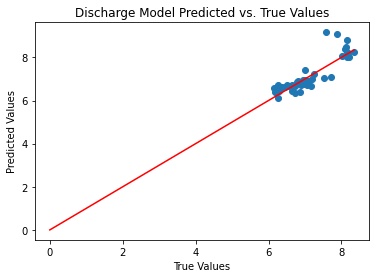

In [40]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [41]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.05
Test RMSE:  0.3759457773795413


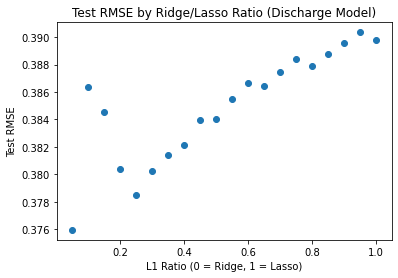

In [42]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

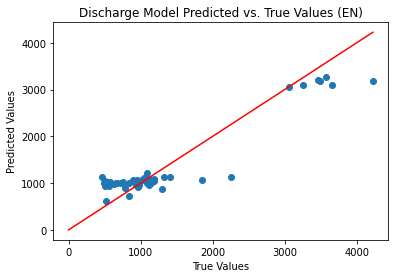

In [64]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

### Full Model

In [45]:
# full model
X_train_full = full_data.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_train = full_data.loc[X_train_full.index][[y]]

X_test_full = full_data.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
y_test = full_data.loc[X_test_full.index][[y]]

if transformations:
    y_train = np.log(y_train)
    y_test = np.log(y_test)
    
reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  0.18456493367950524
Test RMSE:  0.4286101343410878
Mean % Train Error:  0.019496620465799266
Mean % Test Error:  0.03351046579778882


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

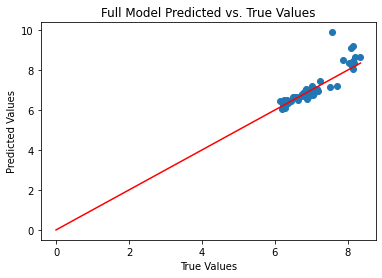

In [48]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [49]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )

    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

Full Elastic Net Model
l1_ratio = 1.0
Test RMSE:  0.5290122026354326


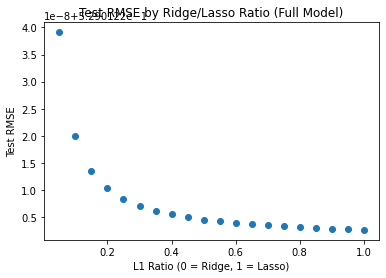

In [50]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN)')

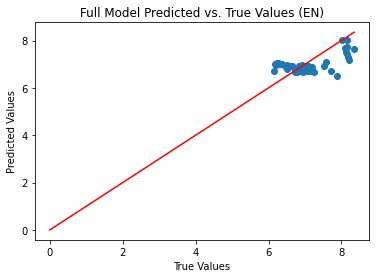

In [51]:
#Elastic Net
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN)")

## Old + New Data Plots

C:\Users\david\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


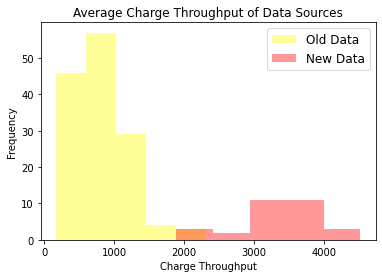

In [70]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=5)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

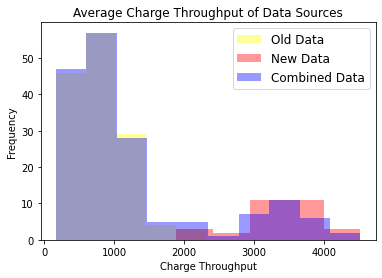

In [71]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=5)
sns.distplot(full_data[y], kde = False, color = "blue", label = 'Combined Data', bins = 10)
# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

In [72]:
all_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                           "Disc (Linear)", "Disc (E.N.)",
                                                           "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en,]})#,

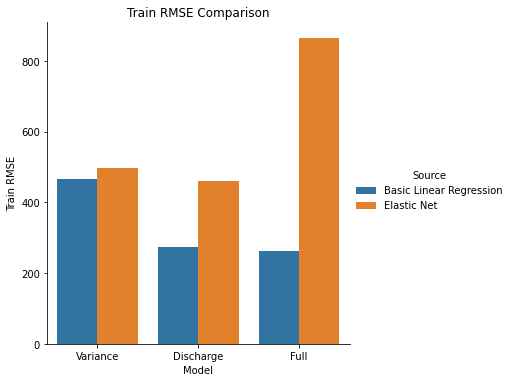

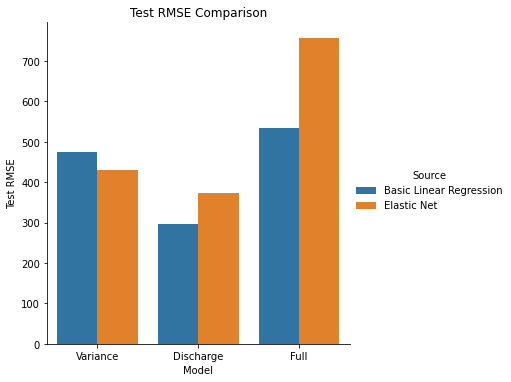

In [74]:
for column in all_data_metrics.columns[3:5]:
    sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")